In [55]:
import pandas as pd
import pickle
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

In [56]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

In [57]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [58]:
input_path_files = "../input_files/spelling_correction_dicts"

# Results of Spelling Correction Methods - Scores and Overlap

## Table of Contents
1. [Introduction](#introduction)<br/>
    1.1 [Function Definition](#functions)<br/>
2. [Holbrook Dataset](#holbrook)<br/>
    2.1 [Holbrook Scores](#holbrook_scores)<br/>
    2.2 [Holbrook Overlap - PySpell vs CMU 0.5](#holbrook_overlap_pyspell_cmu)<br/>
    2.3 [Holbrook Overlap - SymSpell vs CMU 0.5](#holbrook_overlap_symspell_cmu)<br/>
3. [Birkbeck Dataset](#birkbeck)<br/>
    3.1 [Birkbeck Scores](#birkbeck_scores)<br/>
    3.2 [Birbeck Overlap - PySpell](#birkbeck_overlap_pyspell)<br/>
    3.3 [Birkbeck Overlap - SymSpell](#birkbeck_overlap_symspell)<br/>
4. [Zeeko Dataset](#zeeko)<br/>
    4.1 [Zeeko Scores](#zeeko_scores)<br/>
    4.2 [Zeeko Overlap - PySpell](#zeeko_overlap_pyspell)<br/>
    4.3 [Zeeko Overlap - SymSpell](#zeeko_overlap_symspell)<br/>
5. [Aspell Dataset](#aspell)<br/>
    5.1 [Aspell Scores](#aspell_scores)<br/>
    5.2 [Aspell Overlap - PySpell vs CMU 0.5](#aspell_overlap_pyspell_cmu)<br/>
    5.3 [Aspell Overlap - SymSpell vs CMU 0.5](#aspell_overlap_symspell_cmu)<br/>
6. [Wikipedia Dataset](#wiki)<br/>
    6.1 [Wikipedia Scores](#wiki_scores)<br/>
    6.2 [Wikipedia Overlap - PySpell vs CMU 0.5](#wiki_overlap_pyspell)<br/>
    6.3 [Wikipedia Overlap - SymSpell vs CMU 0.5](#wike_overlap_symspell)<br/>

## 1.0 Introduction <a name="introduction"></a>

The purpose of this notebook is to the display the results of the phoneme spelling correction research work carried out. In total, five datasets of spelling mistakes were used for this body of work, they are:

1. [Holbrook](https://www.dcs.bbk.ac.uk/~ROGER/holbrook-missp.dat)
2. [Birkbeck](https://www.dcs.bbk.ac.uk/~ROGER/missp.dat)
3. [Aspell](https://www.dcs.bbk.ac.uk/~ROGER/aspell.dat)
4. [Wikipedia](https://www.dcs.bbk.ac.uk/~ROGER/wikipedia.dat)
5. [Zeeko]()

The first four datasets and their description may be found [here](https://www.dcs.bbk.ac.uk/~ROGER/corpora.html). 

The last dataset, 'Zeeko', is made up of spelling mistakes written in a free form survey by school children. The surveys in their entirety may be see in [zeeko_surveys](https://github.com/robertyoung2/nlp_phoneme_spelling/tree/master/zeeko_surveys).

For each dataset there are three key results included:
* Scores: the accuracy of each method on the given dataset (corrections/total_words).
* Overlap PySpell - the overlap of the CMU Phoneme correction method vs the [PySpell](https://norvig.com/spell-correct.html) word correction method.
* Overlap SymSpell - the overlap of the CMU Phoneme correction method vs the [SymSpell](https://github.com/wolfgarbe/SymSpell) word correction method.

Overlap shows words corrected by either one, other or both of the methods.

**NB**: the luck method for the CMU phoneme method is in a very rough form, and as such it should not be considered for dicussion/inclusion at this time.

## 1.1 Function Definition - Overlap and Scores <a name="functions"></a>

In [59]:
def overlap(dict_1, dict_2, dict_1_name, dict_2_name, data_name, comparison_name):
    """ 
    Calculates the 'overlap' between the results of two spelling correction methods on the same dataset
    
    :param dict_1: the first spelling correction python dictionary object to compare.
    :param dict_2: the second spelling correction python dictionary object to compare.
    :param dict_1_name: the name of the first python dictionary object eg. 'pyspell'.
    :param dict_2_name: the name of the second python dictionary object eg. 'cmu_phonemes'.
    :param data_name: the dataset used eg. 'holbrook'. Used for outputting results to correct directory. \
        Currently used names = ['aspell', 'birkbeck', 'holbrook', 'wiki', 'zeeko']
    :param comparison_name: the comparison of the two methods used eg. 'pyspell_cmu_phonemes'. Used to output \
        to the correct sub-dir. Currently used = ['pyspell_cmu_phonemes', 'symspell_cmu_phonemes']
    :output: Writes the results to the respect directories and sub-directories.
    :return: Returns the values for unique corrections per method, and the overlap between the two.
    
    Example: overlap(holbrook_pyspell, holbrook_phonemes, 'pyspell', 'cmu_phonemes', 'holbrook', \
    'pyspell_cmu_phonemes')
    """
    path = "results/" + data_name + "/" + comparison_name + "/"
    
    both_correct_count = 0
    dict_1_correct_count = 0
    dict_2_correct_count = 0
    
    both_correct_list = []
    dict_1_correct_list = []
    dict_2_correct_list = []
    
    for key in dict_1.keys():
        
        if dict_1[key]['suggested'] == dict_2[key]['suggested']:
            if dict_1[key]['suggested'] == dict_1[key]['correct_spelling']:
                both_correct_count +=1
                mispelling = key
                suggestion = dict_1[key]['correct_spelling']
                both_correct_list.append({'Mispelling':mispelling, 'Suggestion':suggestion})
                
        elif dict_1[key]['suggested'] == dict_1[key]['correct_spelling']:
            dict_1_correct_count += 1
            mispelling = key
            suggestion = dict_1[key]['correct_spelling']
            dict_1_correct_list.append({'Mispelling':mispelling, 'suggestion':suggestion})
            
            
        elif dict_2[key]['suggested'] == dict_2[key]['correct_spelling']:
            dict_2_correct_count +=1
            mispelling = key
            suggestion = dict_2[key]['correct_spelling']
            dict_2_correct_list.append({'Mispelling':mispelling, 'Suggestion':suggestion})
        
    df_both = pd.DataFrame(both_correct_list)
    df_dict_1 = pd.DataFrame(dict_1_correct_list)
    df_dict_2 = pd.DataFrame(dict_2_correct_list)
    
    df_both.to_csv((path+'both.csv'),index=False)
    df_dict_1.to_csv((path+dict_1_name+'.csv'),index=False)
    df_dict_2.to_csv((path+dict_2_name+'.csv'),index=False)
    
    return({'both':both_correct_count, dict_1_name:dict_1_correct_count, dict_2_name:dict_2_correct_count})

In [60]:
def score_application(name, input_dict):
    """
    Calculates and returns the scores for a given method and results dictionary
    :param name: the name of the method as a string eg. 'SymSpell'
    :param input_dict: the input dict of spelling corrections to be score eg. 'holbrook_symspell'
    :returns: a dictionary of results
    """
    correct = 0
    luck = 0
    for misspelling, results in input_dict.items():    
        if results['correct_spelling'] == results['suggested']:
            correct += 1
        if results['correct_spelling'] in results['candidates']:
            luck += 1
            
    correct_and_luck = correct + luck
    
    results = {'Spelling Application':name, 'Correct':correct, 'Luck':luck, 'Correct_and_Luck':correct_and_luck}

    return results

In [61]:
def print_overlap_scores(dict, compare_to):
    compare_to_low = compare_to.lower()
    """Prints the overlap scores for a given input dict of results"""
    total_corrections = dict['both'] + dict[compare_to_low] + dict['cmu_phonemes']
    print("Total corrections:", total_corrections)
    print("Overlap corrections: " + "{:.2f}".format(dict['both'] / total_corrections*100)+"%")
    print("Unqiue corrections " + compare_to + ": " + "{:.2f}".format(dict[compare_to_low] / total_corrections*100)+"%")
    print("Unqiue corrections Phoneme method: " + "{:.2f}".format(dict['cmu_phonemes']/
                                                                 total_corrections*100)+"%")

# 2.0 Holbrook Dataset <a name="holbrook"></a>

In [62]:
# Load Holbrook Spelling dictionaries
file_name_h_pyspell = Path(input_path_files) / "holbrook_pyspell_dict.txt"
holbrook_pyspell = pickle.load(open(file_name_h_pyspell, "rb"))

file_name_h_symspell = Path(input_path_files) / "holbrook_symspell_dict.txt"
holbrook_symspell = pickle.load(open(file_name_h_symspell, "rb"))

file_name_h_phonemes = Path(input_path_files) / "holbrook_phonemes_sym.txt"
holbrook_phonemes = pickle.load(open(file_name_h_phonemes, "rb"))

## 2.1 Holbrook Scores <a name="holbrook_scores"></a>

In [63]:
# Retrieve number of correct results for each method
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Luck', 'Correct_and_Luck'])
results_data = []
results_data.append(score_application('PySpell', holbrook_pyspell))
results_data.append(score_application('CMU Phonemes', holbrook_phonemes))
results_data.append(score_application('SymSpell', holbrook_symspell))
df_spellcheck_vs_cmu.append(results_data)

,Spelling Application,Correct,Luck,Correct_and_Luck
0,PySpell,448,633,1081
1,CMU Phonemes,395,642,1037
2,SymSpell,437,485,922


In [64]:
holbrook_total_words = len(holbrook_pyspell)

In [65]:
print("PySpell Accuracy:",448/holbrook_total_words*100)
print("SymSpell Accuracy:",429/holbrook_total_words*100)
print("Phonemes Accuracy:",355/holbrook_total_words*100)

PySpell Accuracy: 28.681177976952625
SymSpell Accuracy: 27.464788732394368
Phonemes Accuracy: 22.727272727272727


## 2.2 Holbrook Overlap - PySpell vs CMU 0.5 (Phoneme Correction with frequency dictionary) 
<a name="holbrook_overlap_pyspell_cmu"></a>

In [66]:
overlap_holbrook_py_cmu = overlap(holbrook_pyspell, holbrook_phonemes, 'pyspell', 'cmu_phonemes',
                           'holbrook', 'pyspell_cmu_phonemes')

In [67]:
overlap_holbrook_py_cmu

{'both': 198, 'pyspell': 250, 'cmu_phonemes': 197}

#### Version 2 Results - Improved Implementation

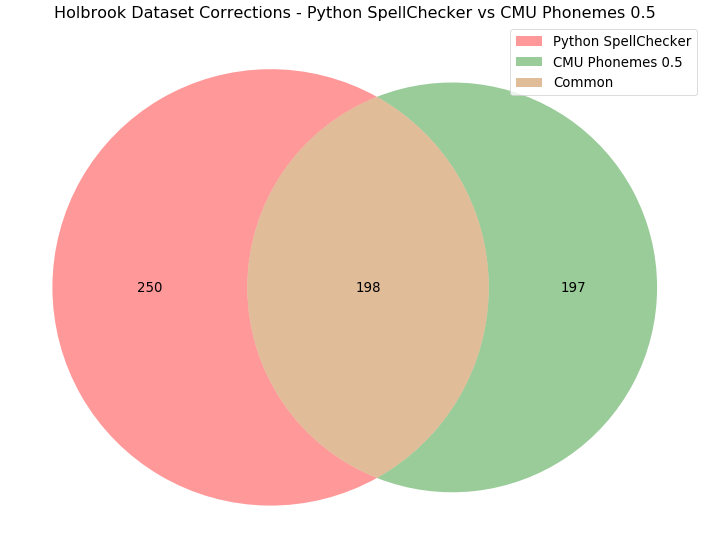

In [68]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_holbrook_py_cmu['pyspell'],overlap_holbrook_py_cmu['cmu_phonemes'],
               overlap_holbrook_py_cmu['both']),set_labels=('','',''))
plt.legend(labels=['Python SpellChecker', 'CMU Phonemes 0.5','Common'])
plt.title('Holbrook Dataset Corrections - Python SpellChecker vs CMU Phonemes 0.5')
plt.show()

In [69]:
print(color.BOLD + "Holbrook Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_holbrook_py_cmu, 'PySpell')

Holbrook Overlap PySpell vs CMU Method 

Total corrections: 645
Overlap corrections: 30.70%
Unqiue corrections PySpell: 38.76%
Unqiue corrections Phoneme method: 30.54%


#### Version 1 Results - Elsa's Initial Implementation

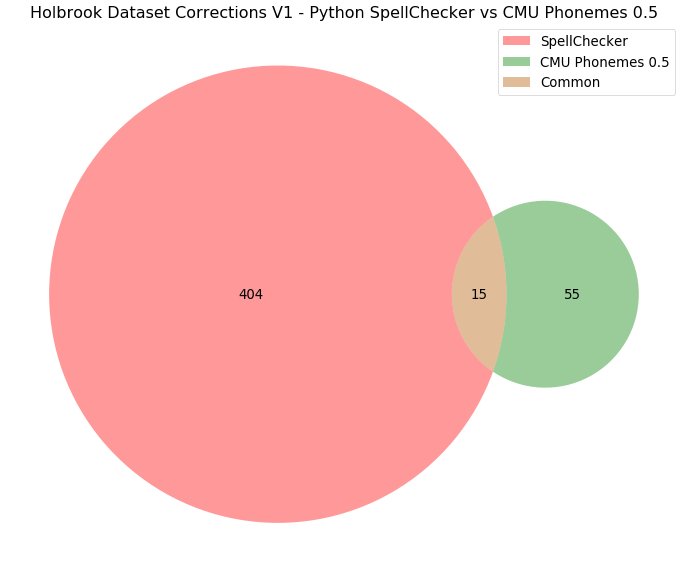

In [70]:
plt.figure(linewidth=5, facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(404,55,15), set_labels=('','',''))
plt.legend(labels=['SpellChecker', 'CMU Phonemes 0.5','Common'])
plt.title('Holbrook Dataset Corrections V1 - Python SpellChecker vs CMU Phonemes 0.5')
plt.show()

## 2.3 Holbrook Overlap - SymSpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="holbrook_overlap_symspell_cmu"></a>

In [71]:
overlap_holbrook_sym_cmu = overlap(holbrook_symspell, holbrook_phonemes, 'symspell', 'cmu_phonemes', 
                                   'holbrook','symspell_cmu_phonemes')

In [72]:
overlap_holbrook_sym_cmu

{'both': 193, 'symspell': 244, 'cmu_phonemes': 202}

#### Version 1 Results - No previous use of SymSpell

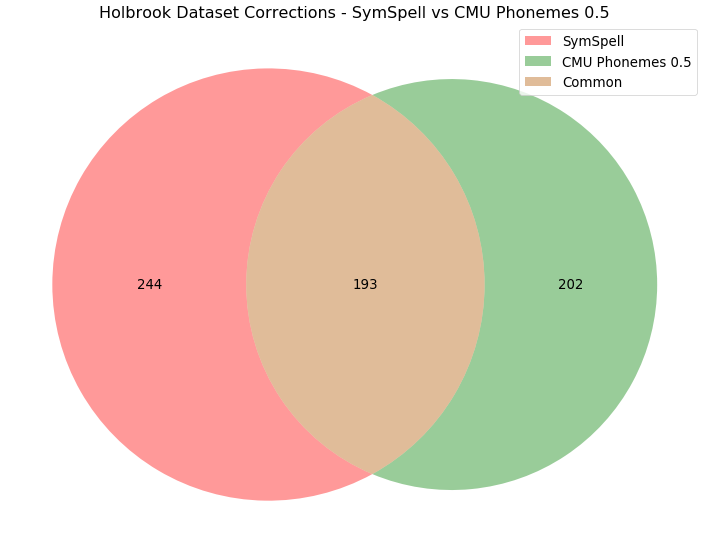

In [73]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_holbrook_sym_cmu['symspell'],overlap_holbrook_sym_cmu['cmu_phonemes'],
               overlap_holbrook_sym_cmu['both']),set_labels=('','',''))
plt.legend(labels=['SymSpell', 'CMU Phonemes 0.5','Common'])
plt.title('Holbrook Dataset Corrections - SymSpell vs CMU Phonemes 0.5')
plt.show()

In [74]:
print(color.BOLD + "Holbrook Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_holbrook_sym_cmu, 'SymSpell')

Holbrook Overlap SymSpell vs CMU Method 

Total corrections: 639
Overlap corrections: 30.20%
Unqiue corrections SymSpell: 38.18%
Unqiue corrections Phoneme method: 31.61%


## 3.0 Birckbeck Dataset <a name="birkbeck"></a>

In [75]:
# Load Birkbeck Spelling dictionaries
file_name_b_pyspell = Path(input_path_files) / "birkbeck_pyspell_dict.txt"
birkbeck_pyspell = pickle.load(open(file_name_b_pyspell, "rb"))

file_name_b_symspell = Path(input_path_files) / "birkbeck_symspell_dict.txt"
birkbeck_symspell = pickle.load(open(file_name_b_symspell, "rb"))

file_name_b_phonemes = Path(input_path_files) / "birkbeck_phonemes_sym.txt"
birkbeck_phonemes = pickle.load(open(file_name_b_phonemes, "rb"))

## 3.1 Birkbeck Scores <a name="birkbeck_scores"></a>

In [76]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Luck', 'Correct_and_Luck'])
results_data = []
results_data.append(score_application('PySpell', birkbeck_pyspell))
results_data.append(score_application('CMU Phonemes', birkbeck_phonemes))
results_data.append(score_application('SymSpell', birkbeck_symspell))

In [77]:
df_spellcheck_vs_cmu.append(results_data)

,Spelling Application,Correct,Luck,Correct_and_Luck
0,PySpell,11767,14148,25915
1,CMU Phonemes,9048,718,9766
2,SymSpell,13122,7996,21118


In [78]:
birkbeck_total_words = len(birkbeck_pyspell)

In [79]:
print("PySpell Accuracy:",11767/birkbeck_total_words*100)
print("SymSpell Accuracy:",11773/birkbeck_total_words*100)
print("Phonemes Accuracy:",9048/birkbeck_total_words*100)

PySpell Accuracy: 34.72423053088205
SymSpell Accuracy: 34.74193643580134
Phonemes Accuracy: 26.7005046182902


## 3.2 Birkbeck Overlap - PySpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="birkbeck_overlap_pyspell"></a>

In [80]:
birkbeck_overlap_py_cmu = overlap(birkbeck_pyspell, birkbeck_phonemes, 'pyspell', 'cmu_phonemes',
                                  'birkbeck', 'pyspell_cmu_phonemes')

In [81]:
birkbeck_overlap_py_cmu

{'both': 5477, 'pyspell': 6290, 'cmu_phonemes': 3571}

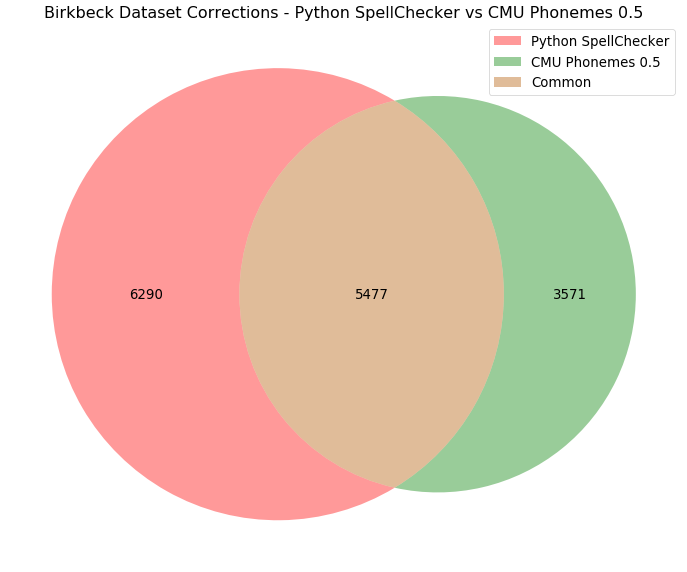

In [82]:
plt.figure(linewidth=5, facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(birkbeck_overlap_py_cmu['pyspell'],birkbeck_overlap_py_cmu['cmu_phonemes'],
               birkbeck_overlap_py_cmu['both']), set_labels=('','',''))
plt.legend(labels=['Python SpellChecker', 'CMU Phonemes 0.5','Common'])
plt.title('Birkbeck Dataset Corrections - Python SpellChecker vs CMU Phonemes 0.5')
plt.show()

In [83]:
print(color.BOLD + "Birkbeck Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(birkbeck_overlap_py_cmu, 'PySpell')

Birkbeck Overlap PySpell vs CMU Method 

Total corrections: 15338
Overlap corrections: 35.71%
Unqiue corrections PySpell: 41.01%
Unqiue corrections Phoneme method: 23.28%


#### Version 1 Results - Elsa's Initial Implementation

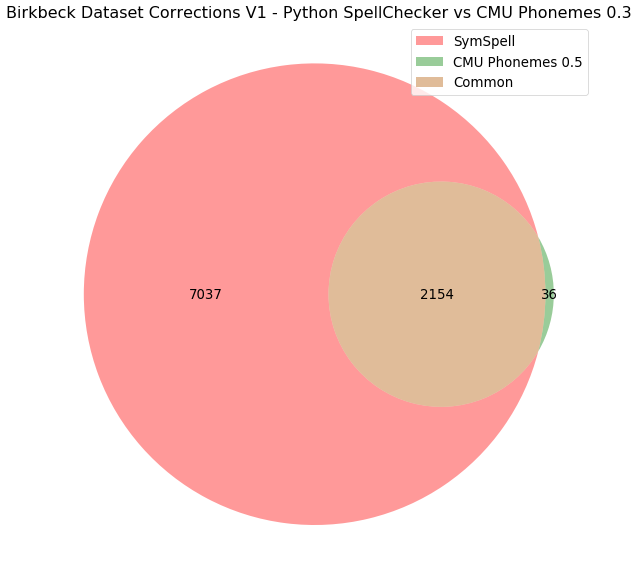

In [84]:
plt.figure(linewidth=5, facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(7037,36,2154), set_labels=('','',''))
plt.legend(labels=['SymSpell', 'CMU Phonemes 0.5','Common'])
plt.title('Birkbeck Dataset Corrections V1 - Python SpellChecker vs CMU Phonemes 0.3')
plt.show()

## 3.3 Birkbeck Overlap - SymSpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="birkbeck_overlap_symspell"></a>

In [85]:
overlap_birkbeck_sym = overlap(birkbeck_symspell, birkbeck_phonemes, 'symspell', 'cmu_phonemes', 
                               'birkbeck', 'symspell_cmu_phonemes')

In [86]:
overlap_birkbeck_sym

{'both': 6087, 'symspell': 7035, 'cmu_phonemes': 2961}

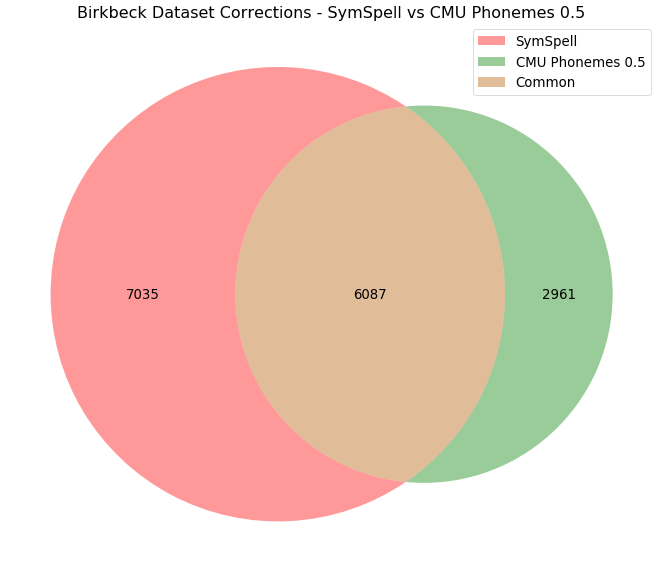

In [87]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_birkbeck_sym['symspell'],overlap_birkbeck_sym['cmu_phonemes'],
               overlap_birkbeck_sym['both']), set_labels=('','',''))
plt.legend(labels=['SymSpell', 'CMU Phonemes 0.5','Common'])
plt.title('Birkbeck Dataset Corrections - SymSpell vs CMU Phonemes 0.5')
plt.show()

In [88]:
print(color.BOLD + "Birkbeck Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_birkbeck_sym, 'SymSpell')

Birkbeck Overlap SymSpell vs CMU Method 

Total corrections: 16083
Overlap corrections: 37.85%
Unqiue corrections SymSpell: 43.74%
Unqiue corrections Phoneme method: 18.41%


# 4.0 Zeeko Dataset <a name="zeeko"></a>

In [89]:
# Load Zeeko Spelling dictionaries
file_name_z_pyspell = Path(input_path_files) / "zeeko_pyspell_dict.txt"
zeeko_pyspell = pickle.load(open(file_name_z_pyspell, "rb"))

file_name_z_symspell = Path(input_path_files) / "zeeko_symspell_dict.txt"
zeeko_symspell = pickle.load(open(file_name_z_symspell, "rb"))

file_name_z_phonemes = Path(input_path_files) / "zeeko_phonemes_sym.txt"
zeeko_phonemes = pickle.load(open(file_name_z_phonemes, "rb"))

## 4.1 Zeeko Scores <a name="zeeko_scores"></a>

In [90]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Luck', 'Correct_and_Luck'])
results_data = []
results_data.append(score_application('PySpell', zeeko_pyspell))
results_data.append(score_application('CMU Phonemes', zeeko_phonemes))
results_data.append(score_application('SymSpell', zeeko_symspell))

In [91]:
df_spellcheck_vs_cmu.append(results_data)

,Spelling Application,Correct,Luck,Correct_and_Luck
0,PySpell,124,153,277
1,CMU Phonemes,83,86,169
2,SymSpell,127,97,224


In [92]:
zeeko_total_words = len(zeeko_symspell)

In [93]:
print("PySpell Accuracy:",124/zeeko_total_words*100)
print("SymSpell Accuracy:",127/zeeko_total_words*100)
print("Phonemes Accuracy:",85/zeeko_total_words*100)

PySpell Accuracy: 53.44827586206896
SymSpell Accuracy: 54.741379310344826
Phonemes Accuracy: 36.637931034482754


## 4.2 Zeeko Overlap - PySpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="zeeko_overlap_pyspell"></a>

In [94]:
overlap_zeeko_py = overlap(zeeko_pyspell, zeeko_phonemes, 'pyspell', 'cmu_phonemes', 'zeeko', 
                           'pyspell_cmu_phonemes')

In [95]:
overlap_zeeko_py

{'both': 57, 'pyspell': 67, 'cmu_phonemes': 26}

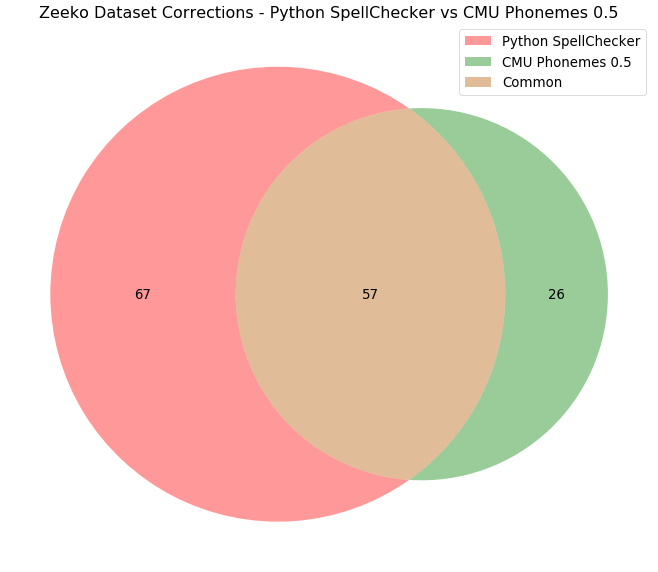

In [96]:
plt.figure(linewidth=5, facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_zeeko_py['pyspell'],overlap_zeeko_py['cmu_phonemes'],overlap_zeeko_py['both']), 
      set_labels=('','',''))
plt.legend(labels=['Python SpellChecker', 'CMU Phonemes 0.5','Common'])
plt.title('Zeeko Dataset Corrections - Python SpellChecker vs CMU Phonemes 0.5')
plt.show()

In [97]:
print(color.BOLD + "Zeeko Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_zeeko_py, 'PySpell')

Zeeko Overlap PySpell vs CMU Method 

Total corrections: 150
Overlap corrections: 38.00%
Unqiue corrections PySpell: 44.67%
Unqiue corrections Phoneme method: 17.33%


## 4.3 Zeeko Overlap - SymSpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="zeeko_overlap_symspell"></a>

In [98]:
overlap_zeeko_sym = overlap(zeeko_symspell, zeeko_phonemes, 'symspell', 'cmu_phonemes', 'zeeko',
                            'symspell_cmu_phonemes')

In [99]:
overlap_zeeko_sym

{'both': 62, 'symspell': 65, 'cmu_phonemes': 21}

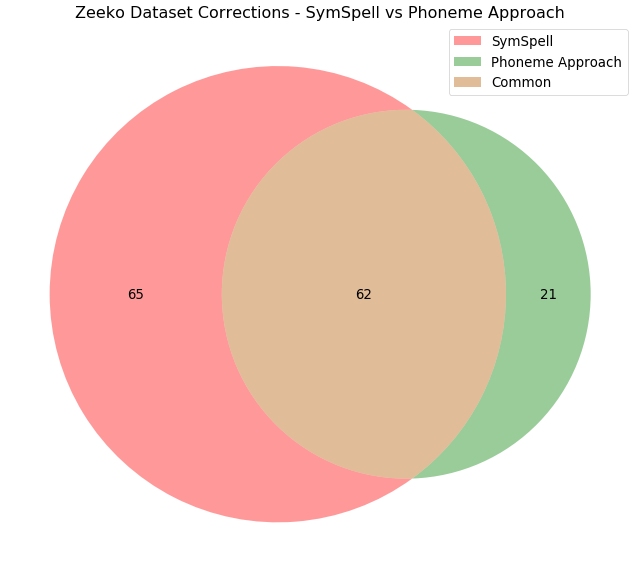

In [100]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_zeeko_sym['symspell'],overlap_zeeko_sym['cmu_phonemes'],overlap_zeeko_sym['both']), 
      set_labels=('','',''))
plt.legend(labels=['SymSpell', 'Phoneme Approach','Common'])
plt.title('Zeeko Dataset Corrections - SymSpell vs Phoneme Approach')
plt.show()

In [101]:
print(color.BOLD + "Zeeko Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_zeeko_sym, 'SymSpell')

Zeeko Overlap SymSpell vs CMU Method 

Total corrections: 148
Overlap corrections: 41.89%
Unqiue corrections SymSpell: 43.92%
Unqiue corrections Phoneme method: 14.19%


In [102]:
overlap_zeeko_sym = overlap(zeeko_symspell, zeeko_phonemes, 'symspell', 'cmu_phonemes', 'zeeko', 
                           'symspell_cmu_phonemes')

In [103]:
overlap_zeeko_sym

{'both': 62, 'symspell': 65, 'cmu_phonemes': 21}

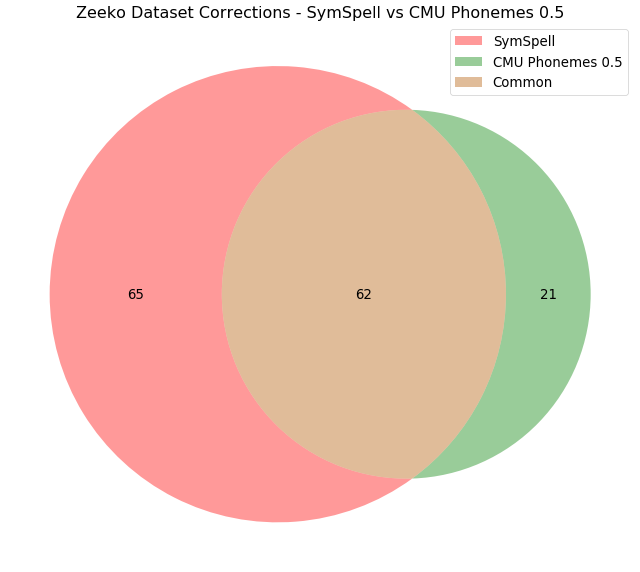

In [104]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_zeeko_sym['symspell'],overlap_zeeko_sym['cmu_phonemes'],overlap_zeeko_sym['both']), 
      set_labels=('','',''))
plt.legend(labels=['SymSpell', 'CMU Phonemes 0.5','Common'])
plt.title('Zeeko Dataset Corrections - SymSpell vs CMU Phonemes 0.5')
plt.show()

# 5.0 Aspell Dataset <a name="aspell"></a>

In [105]:
# Load aspell Spelling dictionaries
file_name_a_pyspell = Path(input_path_files) / "aspell_pyspell_dict.txt"
aspell_pyspell = pickle.load(open(file_name_a_pyspell, "rb"))

file_name_a_symspell = Path(input_path_files) / "aspell_symspell_dict.txt"
aspell_symspell = pickle.load(open(file_name_a_symspell, "rb"))

file_name_a_phonemes = Path(input_path_files) / "aspell_phonemes_sym.txt"
aspell_phonemes = pickle.load(open(file_name_a_phonemes, "rb"))

## 5.1 Aspell Scores <a name="aspell_scores"></a>

In [106]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Luck', 'Correct_and_Luck'])
results_data = []
results_data.append(score_application('PySpell', aspell_pyspell))
results_data.append(score_application('CMU Phonemes', aspell_phonemes))
results_data.append(score_application('SymSpell', aspell_symspell))

In [107]:
df_spellcheck_vs_cmu.append(results_data)

,Spelling Application,Correct,Luck,Correct_and_Luck
0,PySpell,250,315,565
1,CMU Phonemes,221,310,531
2,SymSpell,289,187,476


In [108]:
aspell_total_words = len(aspell_phonemes)

In [109]:
print("PySpell Accuracy:",250/aspell_total_words*100)
print("SymSpell Accuracy:",274/aspell_total_words*100)
print("Phonemes Accuracy:",185/aspell_total_words*100)

PySpell Accuracy: 48.54368932038835
SymSpell Accuracy: 53.20388349514563
Phonemes Accuracy: 35.92233009708738


## 5.2 Aspell Overlap - PySpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="aspell_overlap_pyspell_cmu"></a>

In [110]:
overlap_aspell_py = overlap(aspell_pyspell, aspell_phonemes, 'pyspell', 'cmu_phonemes', 'aspell',
                            'pyspell_cmu_phonemes')

In [111]:
overlap_aspell_py

{'both': 143, 'pyspell': 107, 'cmu_phonemes': 78}

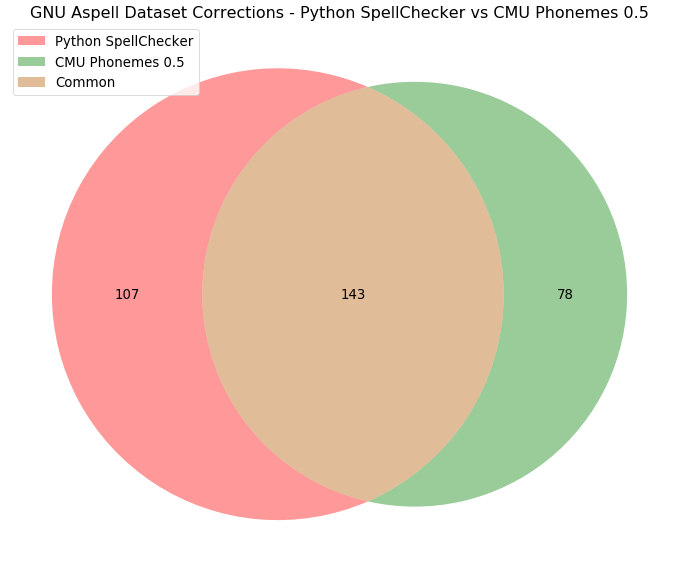

In [112]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_aspell_py['pyspell'],overlap_aspell_py['cmu_phonemes'],
               overlap_aspell_py['both']), set_labels=('','',''))
plt.legend(labels=['Python SpellChecker', 'CMU Phonemes 0.5','Common'])
plt.title('GNU Aspell Dataset Corrections - Python SpellChecker vs CMU Phonemes 0.5')
plt.show()

In [113]:
print(color.BOLD + "Aspell Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_aspell_py, 'PySpell')

Aspell Overlap PySpell vs CMU Method 

Total corrections: 328
Overlap corrections: 43.60%
Unqiue corrections PySpell: 32.62%
Unqiue corrections Phoneme method: 23.78%


## 5.3 Aspell Overlap - SymSpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="aspell_overlap_symspell_cmu"></a>

In [114]:
overlap_aspell_sym = overlap(aspell_symspell, aspell_phonemes, 'symspell', 'cmu_phonemes', 'aspell', 
                             'symspell_cmu_phonemes')

In [115]:
overlap_aspell_sym

{'both': 168, 'symspell': 121, 'cmu_phonemes': 53}

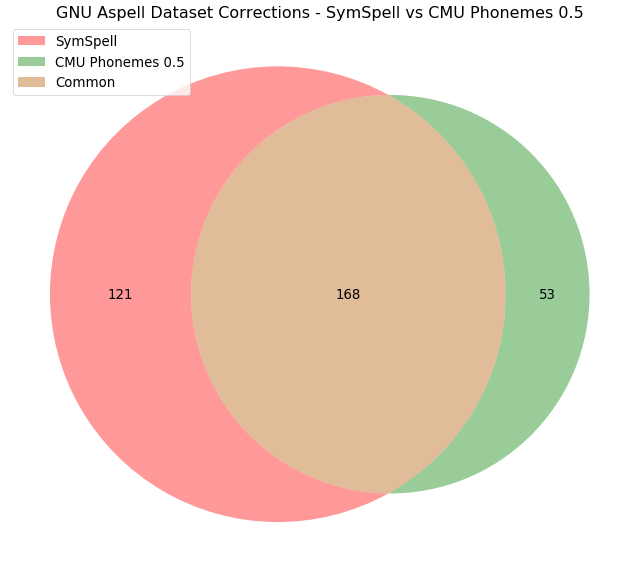

In [116]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_aspell_sym['symspell'],overlap_aspell_sym['cmu_phonemes'],overlap_aspell_sym['both']),
      set_labels=('','',''))
plt.legend(labels=['SymSpell', 'CMU Phonemes 0.5','Common'])
plt.title('GNU Aspell Dataset Corrections - SymSpell vs CMU Phonemes 0.5')
plt.show()

In [117]:
print(color.BOLD + "Aspell Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_aspell_sym, 'SymSpell')

Aspell Overlap SymSpell vs CMU Method 

Total corrections: 342
Overlap corrections: 49.12%
Unqiue corrections SymSpell: 35.38%
Unqiue corrections Phoneme method: 15.50%


# 6.0 Wikipedia Dataset <a name="wiki"><a/>

In [118]:
# Load wiki Spelling dictionaries
file_name_w_pyspell = Path(input_path_files) / "wiki_pyspell_dict.txt"
wiki_pyspell = pickle.load(open(file_name_w_pyspell, "rb"))

file_name_w_symspell = Path(input_path_files) / "wiki_symspell_dict.txt"
wiki_symspell = pickle.load(open(file_name_w_symspell, "rb"))

file_name_w_phonemes = Path(input_path_files) / "wiki_phonemes_sym.txt"
wiki_phonemes = pickle.load(open(file_name_w_phonemes, "rb"))

## 6.1 Wikipedia Scores <a name="wiki_scores"></a>

In [119]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Luck', 'Correct_and_Luck'])
results_data = []
results_data.append(score_application('PySpell', wiki_pyspell))
results_data.append(score_application('CMU Phonemes', wiki_phonemes))
results_data.append(score_application('SymSpell', wiki_symspell))

In [120]:
df_spellcheck_vs_cmu.append(results_data)

,Spelling Application,Correct,Luck,Correct_and_Luck
0,PySpell,1740,1956,3696
1,CMU Phonemes,1264,1529,2793
2,SymSpell,1813,681,2494


In [121]:
wiki_total_words = len(wiki_phonemes)

In [122]:
print("PySpell Accuracy:",1740/wiki_total_words*100)
print("SymSpell Accuracy:",1806/wiki_total_words*100)
print("Phonemes Accuracy:",1123/wiki_total_words*100)

PySpell Accuracy: 78.02690582959642
SymSpell Accuracy: 80.98654708520179
Phonemes Accuracy: 50.35874439461884


## 6.2 Wikipedia Overlap - PySpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="wiki_overlap_pyspell"></a>

In [123]:
overlap_wiki_py = overlap(wiki_pyspell, wiki_phonemes, 'pyspell', 'cmu_phonemes', 'wiki', 
                          'pyspell_cmu_phonemes')

In [124]:
overlap_wiki_py

{'both': 1044, 'pyspell': 696, 'cmu_phonemes': 220}

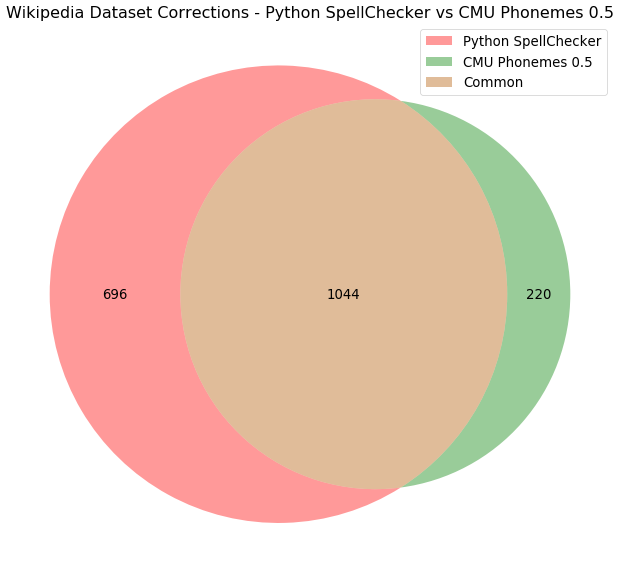

In [125]:
plt.figure(linewidth=5, facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_wiki_py['pyspell'],overlap_wiki_py['cmu_phonemes'],overlap_wiki_py['both']), set_labels=('','',''))
plt.legend(labels=['Python SpellChecker', 'CMU Phonemes 0.5','Common'])
plt.title('Wikipedia Dataset Corrections - Python SpellChecker vs CMU Phonemes 0.5')
plt.show()

In [126]:
print(color.BOLD + "Wikipedia Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_wiki_py, 'PySpell')

Wikipedia Overlap PySpell vs CMU Method 

Total corrections: 1960
Overlap corrections: 53.27%
Unqiue corrections PySpell: 35.51%
Unqiue corrections Phoneme method: 11.22%


## 6.3 Wikipedia Overlap - SymSpell vs CMU 0.5 (Phoneme Correction with frequency dictionary)
<a name="wike_overlap_symspell"></a>

In [127]:
overlap_wiki_sym = overlap(wiki_symspell, wiki_phonemes, 'symspell', 'cmu_phonemes', 'wiki', 
                           'symspell_cmu_phonemes')

In [128]:
overlap_wiki_sym

{'both': 1091, 'symspell': 722, 'cmu_phonemes': 173}

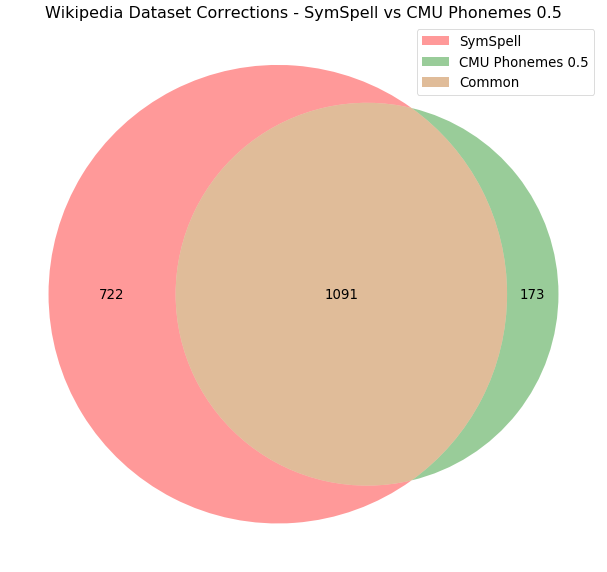

In [129]:
plt.figure(linewidth=5,  facecolor="white", figsize=(15,12), dpi=60)
venn2(subsets=(overlap_wiki_sym['symspell'],overlap_wiki_sym['cmu_phonemes'],overlap_wiki_sym['both']), 
      set_labels=('','',''))
plt.legend(labels=['SymSpell', 'CMU Phonemes 0.5','Common'])
plt.title('Wikipedia Dataset Corrections - SymSpell vs CMU Phonemes 0.5')
plt.show()

In [130]:
print(color.BOLD + "Aspell Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_wiki_sym, 'SymSpell')

Aspell Overlap SymSpell vs CMU Method 

Total corrections: 1986
Overlap corrections: 54.93%
Unqiue corrections SymSpell: 36.35%
Unqiue corrections Phoneme method: 8.71%
